### Named Entity Recognition Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import json
import nltk
import spacy
import glob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

#### A. Preliminaries

In [2]:
# read data aggregate
def read_data(files):
    all = []
    for file in files:
        try:
            with open(file, 'r') as doc:
                data = [json.loads(line) for line in doc]
                all.extend(data)
        except Exception as e: 
            print(f"Error reading file '{file}': {e}")

    return all

In [3]:
all_files = glob.glob('data/' + '*.jsonl')
data_list = read_data(all_files)
data_df = pd.DataFrame(data_list)

Error reading file 'data/NER Cohort 1-EN-F.jsonl': Expecting value: line 2 column 1 (char 1)


In [4]:
# load spacy english model
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner"])

/Users/janinedevera/Documents/UNDP/NER/named-entity-recognition-undp/ner-env/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.7.1) was trained with spaCy v3.7.2 and may not be 100% compatible with the current version (3.7.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


#### B. Checks 1
##### Duplicates

In [5]:
def preprocess_text(docs):
    texts = [nlp(x) for x in docs]
    result = []

    for text in texts: 
        tokens = [token.lemma_ for token in text if not token.is_stop and token.is_alpha or token.is_digit]
        result.append(" ".join(tokens))

    return result

In [6]:
# extract text as list 
text_list = [x['text'] for x in data_list]
text_processed = preprocess_text(text_list)

/Users/janinedevera/Documents/UNDP/NER/named-entity-recognition-undp/ner-env/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [7]:
# vectorize and compute similarity score
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(text_processed)
similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
similarity_threshold = 0.98

In [8]:
# extract duplicate texts 
duplicates = set()
for i in range(len(text_list)):
    for j in range(i + 1, len(text_list)):
        if similarity_matrix[i, j] > similarity_threshold:
            duplicates.add((i, j))
print(f"Number of duplicates: {len(duplicates)}")

Number of duplicates: 34


##### Language

In [9]:
lang_list = set([x['language'] for x in data_list])
lang_list

{'eng'}

##### Null Labels

In [10]:
# check number of texts with no labels
no_labels = [(item["text"], item["label"]) for item in data_list if not item["label"]]
print(f"Number of empty lists: {len(no_labels)}")

Number of empty lists: 3167


In [11]:
for text, label in no_labels:
    print(f"Text: {text}")

Text: A MAJOR OBSTACLE on the road to our countries’ social and economic progress.
Text: The partnership also provided for the drilling of wells.
Text: The limitation of the liability of shareholders to the amount outstanding on the shares, by enlarging the number of potential participants in business finance, extends very greatly the capital "watershed".
Text: The family of analytical techniques for examining economic environmental policies and decisions includes traditional project level cost-benefit analysis, cost-effectiveness analysis, multicriteria analysis and decision analysis.
Text: Thus, enabling the housing sector to work better is critical for preventing the multiplication of slums and promoting sustainable urban development.
Text: Do gender relations within health services affect the process of health sector reform, attempts should not be the experiences of users?
Text: They are also more vulnerable to violence like sexual assault and abuse during environmental crises.
Tex

#### C. Checks 2

##### Label Cardinality
Average number of labels assigned to each instance in a dataset

*https://www.professores.uff.br/fcbernardini/wp-content/uploads/sites/68/2017/08/2Bernardini_Barbosa_Meza-ENIAC2013.pdf*

In [12]:
# separate dataset by group/volunteer
groups = set(x['group'] for x in data_list)

grouped_data = []
for value in groups:
    group = [d for d in data_list if d['group'] == value]
    grouped_data.append(group)

In [13]:
# label list by group/volunteer
label_list = []
for group in grouped_data:
    labels = [x['label'] for x in group]
    label_list.append(labels)

ent_list = [[[
    [item for item in sublist if isinstance(item, str)]
    for sublist in inner_list_1
] for inner_list_1 in inner_list_2] for inner_list_2 in label_list]


In [49]:
# calculate label cardinality
for index, group in enumerate(ent_list): 
    total_labels = sum(len(instance_lables) for instance_lables in group)
    n = len(group)
    cardinality = total_labels / n
    print(f"Cardinality of group {index+1}: {cardinality:.3f}")


Cardinality of group 1: 2.000
Cardinality of group 2: 2.306
Cardinality of group 3: 2.231
Cardinality of group 4: 1.823
Cardinality of group 5: 2.154
Cardinality of group 6: 2.643
Cardinality of group 7: 2.581
Cardinality of group 8: 2.876
Cardinality of group 9: 1.879
Cardinality of group 10: 2.714
Cardinality of group 11: 2.149
Cardinality of group 12: 2.401
Cardinality of group 13: 1.824


##### Label Density
Average number of labels assigned to each instance out of total unique labels

In [55]:
# calculate label density
for index, group in enumerate(ent_list):
    label_sum = 0
    for sublist in group: 
        unique_labels = len(list(set([item for inner_list in sublist for item in inner_list])))
        label_sum += unique_labels
    n = len(list(set([item for sublist in group for inner_list in sublist for item in inner_list])))
    mean_labels = label_sum / n
    density = mean_labels / len(group)
    print(f"Density of group {index+1}: {density:.3f}, size of group: {len(group)}, unique labels: {n}")

Density of group 1: 0.108, size of group: 20, unique labels: 12
Density of group 2: 0.075, size of group: 2500, unique labels: 21
Density of group 3: 0.073, size of group: 2089, unique labels: 21
Density of group 4: 0.064, size of group: 1304, unique labels: 20
Density of group 5: 0.070, size of group: 2020, unique labels: 22
Density of group 6: 0.079, size of group: 2010, unique labels: 22
Density of group 7: 0.086, size of group: 372, unique labels: 21
Density of group 8: 0.093, size of group: 688, unique labels: 22
Density of group 9: 0.065, size of group: 1129, unique labels: 21
Density of group 10: 0.105, size of group: 49, unique labels: 18
Density of group 11: 0.075, size of group: 342, unique labels: 20
Density of group 12: 0.076, size of group: 2500, unique labels: 22
Density of group 13: 0.063, size of group: 2010, unique labels: 21


##### Label Distribution by Group

In [88]:
ent_dict = {}
for index, group in enumerate(ent_list):
    group_labels = [item for sublist in group for inner_list in sublist for item in inner_list]
    frequency_counter = Counter(group_labels)
    percent = {label: count / len(group_labels) for label, count in frequency_counter.items()}
    ent_dict[index + 1] = percent

In [92]:
rows = list(ent_dict.keys())
columns = sorted(set(col for row_dict in ent_dict.values() for col in row_dict.keys()))
ent_array = [[ent_dict[row].get(col, 0) for col in columns] for row in rows]

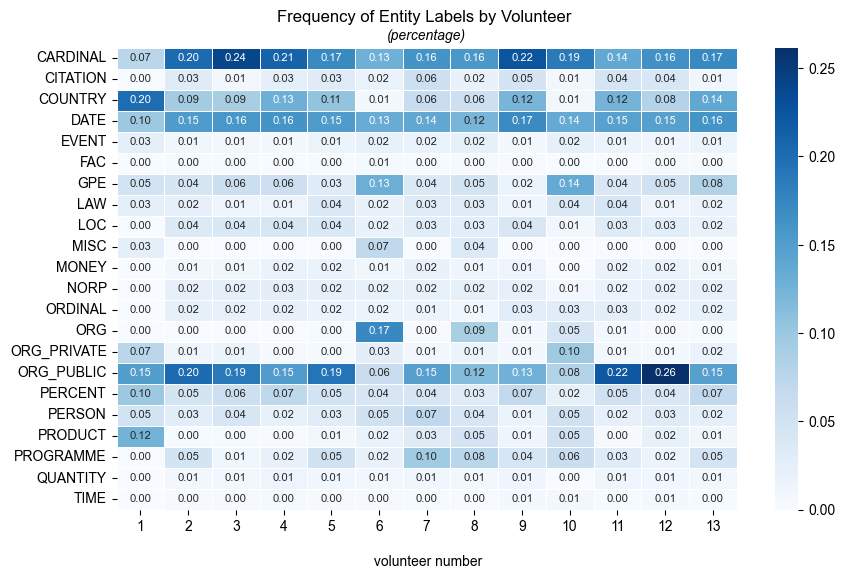

In [152]:
rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(10, 6)) 
sns.heatmap(np.transpose(ent_array), fmt=".2f", cmap="Blues", xticklabels=rows, yticklabels=columns,
            linewidth=.5, annot=True, annot_kws={"size": 8})
plt.xlabel('\n volunteer number')
plt.title('Frequency of Entity Labels by Volunteer \n')
plt.text(0.5, 1.01, "(percentage)", horizontalalignment='center', verticalalignment='bottom', 
         transform=ax.transAxes, fontstyle='italic')
plt.savefig('plots/01 label distribution.png', dpi=300)
plt.show()

##### Label Distribution Total

In [99]:
label_list = [x['label'] for x in data_list]
flattened_list = [item for sublist in label_list for item in sublist]

ent_list = [item[2] for item in flattened_list] # extract only entity labels
frequency_counter = Counter(ent_list)
for item, frequency in frequency_counter.items():
    print(f"{item}: {frequency}")

CARDINAL: 6898
FAC: 111
QUANTITY: 362
NORP: 853
GPE: 2313
PRODUCT: 480
DATE: 5705
ORG_PUBLIC: 6498
ORDINAL: 737
LOC: 1205
PERSON: 1315
PROGRAMME: 1326
COUNTRY: 3289
PERCENT: 1940
EVENT: 509
CITATION: 1012
LAW: 787
ORG_PRIVATE: 488
MONEY: 497
TIME: 151
ORG: 1172
MISC: 456


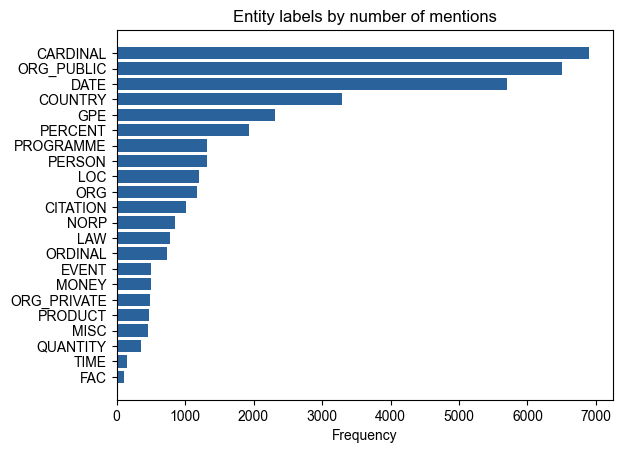

In [122]:
items, frequencies = zip(*sorted(frequency_counter.items(), key=lambda x: x[1]))

plt.barh(items, frequencies, color='#2a639c')
plt.xlabel('Frequency')
plt.title('Entity labels by number of mentions')
plt.show()

##### Token Length

In [101]:
texts = [nlp(x) for x in text_list]
num_tokens = [len(text) for text in texts]

/Users/janinedevera/Documents/UNDP/NER/named-entity-recognition-undp/ner-env/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [174]:
min, max = np.min(num_tokens), np.max(num_tokens)
mean, med, sd = np.mean(num_tokens), np.median(num_tokens), np.std(num_tokens)

print(f"Summary Statistics: \n Min = {min} \n Max = {max} \n Mean = {round(mean, 1)} \n Median = {round(med, 1)} \n SD = {round(sd,1)}")

Summary Statistics: 
 Min = 5 
 Max = 256 
 Mean = 30.4 
 Median = 27.0 
 SD = 18.7


In [175]:
matching_indices = [i for i, num in enumerate(num_tokens) if num == min]

if matching_indices:
    for index in matching_indices:
        print(f"Text {index}: {text_list[index]}")

Text 1849: Bahamas 52 .. 1,002 ..
Text 3074: Seventh Ee s slon .
Text 3462: A regional debt crisis ........................................................................................
